In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# reading the data from the disk into memory
df = pd.read_csv("train.csv")
colnames = df.columns
colnames

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
# create a new dataframe with select features
X = pd.DataFrame()
parameters = {1, 2, 4, 5, 6, 7}
for i in parameters:
    X[colnames[i]] = df[colnames[i]]

In [4]:
# regress Age on SibSp and Parch
from sklearn.linear_model import LinearRegression
A = pd.DataFrame()
A['Age'] = df['Age']
A['SibSp'] = df['SibSp']
A['Parch'] = df['Parch']
A_dropped = A.dropna(axis = 0)
b = A_dropped['Age']
A_dropped = A_dropped.drop(['Age'], axis = 1)
clf = LinearRegression()
clf.fit(A_dropped, b)
newAge = pd.DataFrame()
coefficients = clf.coef_
intercept = clf.intercept_
#avgAge = df.Age.mean()
#df.Age = df.Age.fillna(value = avgAge)

In [5]:
# replace null Age values with regression estimated results
for i in range(0, A.shape[0]):
    if pd.isnull(A.Age[i]):
        A.iloc[i,0] = intercept + (coefficients[0]*A.SibSp[i]) + (coefficients[1]*A.Parch[i])
X.Age = A.Age # insert new Age Column Values into X

In [6]:
# fill missing age with mean of 'Age', 'SibSp' and 'Parch'
#avgAge = df.Age.mean()
#df.Age = df.Age.fillna(value = avgAge)
# drop remaining missing values
X = X.dropna(axis = 0)

In [7]:
# split Y-output from features
y = X[colnames[1]]
X = X.drop([colnames[1]], axis = 1)

In [8]:
# tranform Sex & Pclass into dummy variables
X[colnames[4]] = pd.get_dummies(X.Sex)['female'] #drop 'male' dummy
# add Pclass dummies for 1 and 2 and drop Pclass
X['Pclass1'] = pd.get_dummies(X.Pclass)[1]
X['Pclass2'] = pd.get_dummies(X.Pclass)[2]
X = X.drop([colnames[2]], axis = 1)

In [9]:
# scale features
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
# create base rate model predicting everyone dies
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

In [12]:
# base rate model accuracy
y_base_rate = base_rate_model(X_test)
from sklearn.metrics import accuracy_score
print("Base rate accuracy is %2.2f" % accuracy_score(y_test, y_base_rate))

Base rate accuracy is 0.59


In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l2', C = 1)

In [14]:
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
print("Logistic accuracy is %2.2f" % accuracy_score(y_test, model.predict(X_test)))

Logistic accuracy is 0.81


In [16]:
# calculate AUC scores
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
print("---Base Model---")
#base rate AUC
base_roc_auc = roc_auc_score(y_test, base_rate_model(X_test))
print("Base Rate AUC = %2.2f" % base_roc_auc)
print(classification_report(y_test, base_rate_model(X_test)))
print("\n\n---Logit Model---")
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print("Logistic Rate AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, model.predict(X_test)))

---Base Model---
Base Rate AUC = 0.50
             precision    recall  f1-score   support

          0       0.59      1.00      0.74       105
          1       0.00      0.00      0.00        74

avg / total       0.34      0.59      0.43       179



---Logit Model---
Logistic Rate AUC = 0.80
             precision    recall  f1-score   support

          0       0.82      0.87      0.84       105
          1       0.79      0.73      0.76        74

avg / total       0.81      0.81      0.81       179



C:\Users\leeda\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


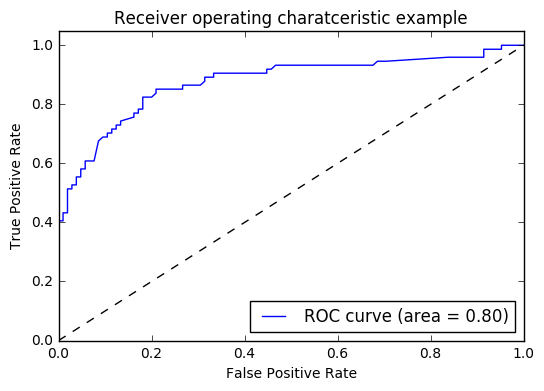

In [17]:
# plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating charatceristic example')
plt.legend(loc = 'lower right')
plt.show()

### Concluding Notes
+ Features Selected

> Age (null values replaced estimates from regressing Age on SibSp & Parch

> Sex

> Pclass (dummy variables Pclass1 & Pclass2)

> SibSp

> Parch

+ 0.81 Logit Model Accuracy
+ 0.80 Logit Rate AUC

#### *Possible model error/bias resulting from using SibSp and Parch for both estimating null values of Age and within the Logit Model